# **Libraries**

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import pickle
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import torchvision
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
import os
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
Categories=['trash','recycle','organics', 'hazardous']

In [ ]:
!pip install -U torchtext==0.6

  Using cached torchtext-0.6.0-py3-none-any.whl (64 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

# **Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir="/content/drive/MyDrive/APS360/APS360 Project/APS360 Process Report Dataset/train"
val_dir="/content/drive/MyDrive/APS360/APS360 Project/APS360 Process Report Dataset/val"
test_dir="/content/drive/MyDrive/APS360/APS360 Project/Create Your Own Test Set"

In [ ]:
small_train_dir="/content/drive/MyDrive/APS360/APS360 Project/Process Report Small Dataset/train"
small_val_dir="/content/drive/MyDrive/APS360/APS360 Project/Process Report Small Dataset/val"

In [ ]:
torch.manual_seed(1)

# Apply transformations
transform = transforms.Compose([
    transforms.Resize(256),            # Resize to 256x256 pixels
    transforms.CenterCrop(224),        # Crop to 224x224 pixels
    # 224: standard input size for AlexNet, VGG, and ResNet
    # images to tensors: normalizes pixel values and allows for mathematical operations within NN
    transforms.ToTensor(),             # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and standard deviation
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Set up data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## For small dataset
small_train_dataset = datasets.ImageFolder(small_train_dir, transform=transform)
small_val_dataset = datasets.ImageFolder(small_val_dir, transform=transform)

# Set up data loaders
small_train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True)
small_validation_loader = DataLoader(small_val_dataset, batch_size=32, shuffle=False)

# **Using Pretrained AlexNet**

In [ ]:
# Using pretrained AlexNet
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = torch.nn.Linear(alexnet.classifier[6].in_features, 4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

In [ ]:
# Need to freeze parameters
# Before training, ensure only the last layer's parameters are unfrozen
for param in alexnet.features.parameters():
    param.requires_grad = False  # Freeze all the features layers

# Unfreeze the newly replaced last layer in the classifier
for param in alexnet.classifier.parameters():
    param.requires_grad = True  # Unfreeze the classifier layer

In [ ]:
def get_accuracy(model, data_loader):
    data = data_loader

    correct = 0
    total = 0
    for imgs, labels in data:



        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
import torchtext
def train_net(model, train_loader, val_loader, batch_size=32,
              lr=0.001, num_epochs=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    # Use optimizer only on unfrozen parameters (i.e., those that require gradients)
    # this line is added for using pretrained alexnet model
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    losses, train_acc, valid_acc = [], [], []   # for graph
    epochs = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        train_preds = []
        train_targets = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(train_targets, train_preds)
        epoch_f1 = f1_score(train_targets, train_preds, average='weighted')

        epochs.append(num_epochs)   # for graph
        train_acc.append(epoch_acc)
        losses.append(epoch_loss)

        model.eval()  # Set model to evaluate mode
        val_running_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds, average='weighted')

        valid_acc.append(val_acc)   # for graph

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Accuracy: {epoch_acc:.4f}, F1-Score: {epoch_f1:.4f}, Loss: {epoch_loss:.4f}')
        print(f'Valid Accuracy: {val_acc:.4f}, F1-Score: {val_f1:.4f}, Loss: {val_loss:.4f}, ')

        model_path = "bs{0}_lr{1}_epoch{2}".format(batch_size, lr, epoch)
        torch.save(model.state_dict(), model_path)

    # Plot Loss
    plt.plot(losses, label="Train Loss")
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(train_acc, label="Training")
    plt.plot(valid_acc, label="Validation")
    plt.title("Training and Validation Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

## Training performances

### Batch size (selected to be 64)

Epoch 1/15
Train Accuracy: 0.8633, F1-Score: 0.8637, Loss: 0.6779
Valid Accuracy: 0.8000, F1-Score: 0.7787, Loss: 2.1012, 
Epoch 2/15
Train Accuracy: 0.9250, F1-Score: 0.9248, Loss: 0.4001
Valid Accuracy: 0.8600, F1-Score: 0.8546, Loss: 1.6602, 
Epoch 3/15
Train Accuracy: 0.9333, F1-Score: 0.9333, Loss: 0.3632
Valid Accuracy: 0.8500, F1-Score: 0.8454, Loss: 1.4956, 
Epoch 4/15
Train Accuracy: 0.9533, F1-Score: 0.9532, Loss: 0.3524
Valid Accuracy: 0.8150, F1-Score: 0.8070, Loss: 2.3502, 
Epoch 5/15
Train Accuracy: 0.9350, F1-Score: 0.9351, Loss: 0.6862
Valid Accuracy: 0.8950, F1-Score: 0.8954, Loss: 1.4359, 
Epoch 6/15
Train Accuracy: 0.9517, F1-Score: 0.9517, Loss: 0.5656
Valid Accuracy: 0.8450, F1-Score: 0.8419, Loss: 2.5522, 
Epoch 7/15
Train Accuracy: 0.9667, F1-Score: 0.9667, Loss: 0.4602
Valid Accuracy: 0.8450, F1-Score: 0.8454, Loss: 3.0908, 
Epoch 8/15
Train Accuracy: 0.9700, F1-Score: 0.9700, Loss: 0.2842
Valid Accuracy: 0.8150, F1-Score: 0.8146, Loss: 3.0200, 
Epoch 9/15
Train

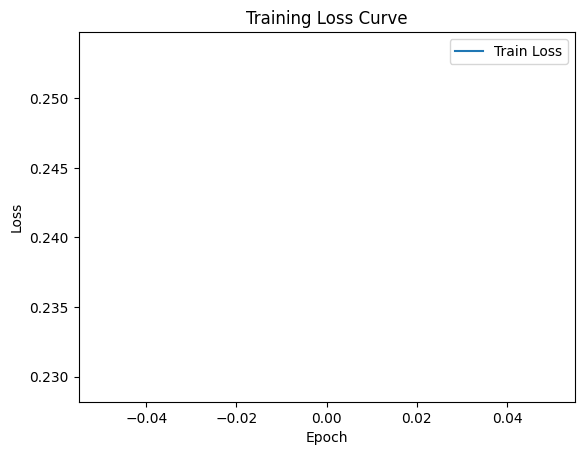

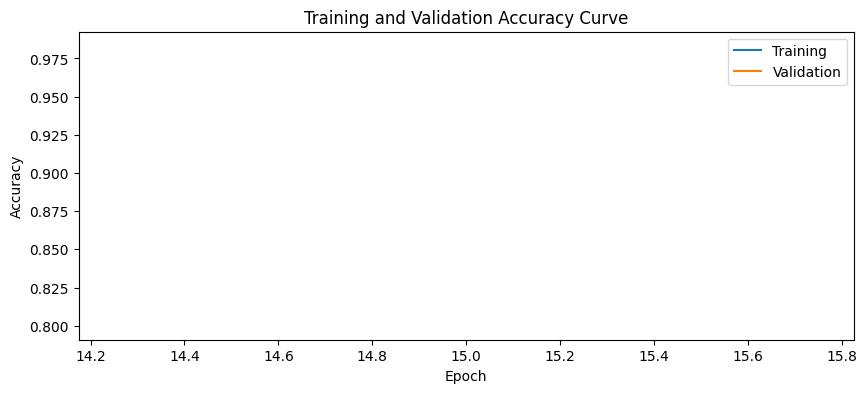

In [ ]:
'''
batch size = 32, lr = 0.001:
Train Accuracy: 0.9617, F1-Score: 0.9617, Loss: 0.3156
Valid Accuracy: 0.8800, F1-Score: 0.8803, Loss: 1.9768,
Best model path: /content/bs32_lr0.001_epoch9
'''

train_net(alexnet, train_loader, validation_loader, batch_size=32, lr=0.001, num_epochs=15)

Epoch 1/15
Train Accuracy: 0.9850, F1-Score: 0.9850, Loss: 0.2734
Valid Accuracy: 0.9150, F1-Score: 0.9149, Loss: 3.1142, 
Epoch 2/15
Train Accuracy: 0.9883, F1-Score: 0.9883, Loss: 0.1929
Valid Accuracy: 0.9100, F1-Score: 0.9106, Loss: 2.9360, 
Epoch 3/15
Train Accuracy: 0.9700, F1-Score: 0.9701, Loss: 0.6806
Valid Accuracy: 0.8400, F1-Score: 0.8373, Loss: 11.0677, 
Epoch 4/15
Train Accuracy: 0.9550, F1-Score: 0.9548, Loss: 1.4030
Valid Accuracy: 0.8800, F1-Score: 0.8808, Loss: 5.3171, 
Epoch 5/15
Train Accuracy: 0.9883, F1-Score: 0.9883, Loss: 0.1465
Valid Accuracy: 0.8850, F1-Score: 0.8838, Loss: 6.1096, 
Epoch 6/15
Train Accuracy: 0.9933, F1-Score: 0.9933, Loss: 0.0846
Valid Accuracy: 0.8800, F1-Score: 0.8775, Loss: 6.1980, 
Epoch 7/15
Train Accuracy: 0.9767, F1-Score: 0.9767, Loss: 0.6875
Valid Accuracy: 0.8300, F1-Score: 0.8169, Loss: 9.5907, 
Epoch 8/15
Train Accuracy: 0.9750, F1-Score: 0.9750, Loss: 0.8071
Valid Accuracy: 0.8500, F1-Score: 0.8516, Loss: 10.2935, 
Epoch 9/15
Tra

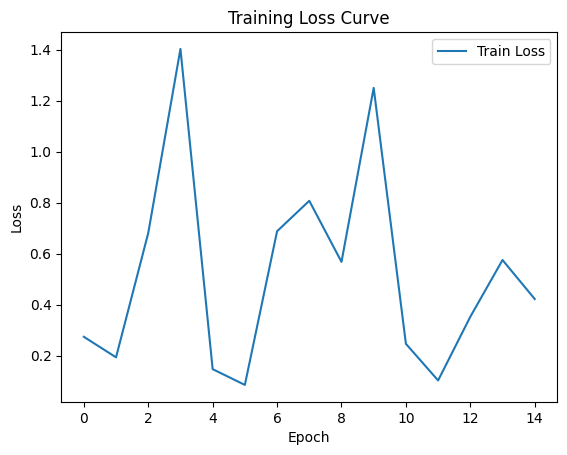

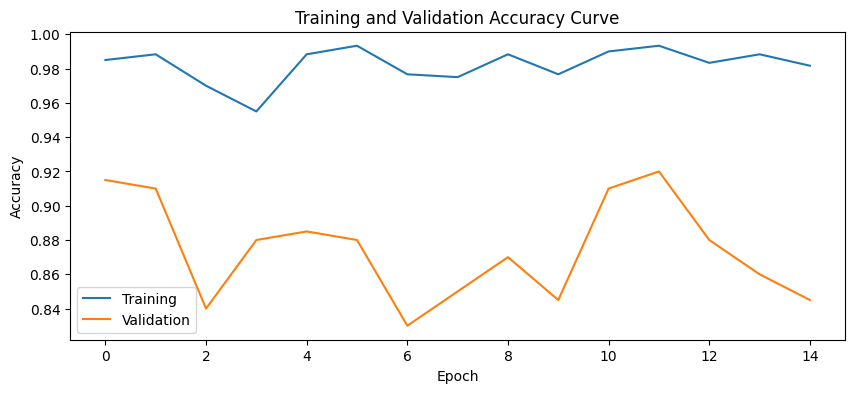

In [ ]:
'''
batch size = 64, lr = 0.001:
Train Accuracy: 0.9933, F1-Score: 0.9933, Loss: 0.1022
Valid Accuracy: 0.9200, F1-Score: 0.9205, Loss: 5.0973,
Best model path: /content/bs64_lr0.001_epoch11
'''

train_net(alexnet, train_loader, validation_loader, batch_size=64, lr=0.001, num_epochs=15)

Epoch 1/15
Train Accuracy: 0.9917, F1-Score: 0.9917, Loss: 0.5063
Valid Accuracy: 0.8950, F1-Score: 0.8944, Loss: 5.2570, 
Epoch 2/15
Train Accuracy: 0.9967, F1-Score: 0.9967, Loss: 0.0128
Valid Accuracy: 0.8450, F1-Score: 0.8441, Loss: 6.1113, 
Epoch 3/15
Train Accuracy: 0.9967, F1-Score: 0.9967, Loss: 0.0088
Valid Accuracy: 0.8850, F1-Score: 0.8855, Loss: 5.2794, 
Epoch 4/15
Train Accuracy: 0.9933, F1-Score: 0.9933, Loss: 0.0511
Valid Accuracy: 0.8800, F1-Score: 0.8792, Loss: 6.4538, 
Epoch 5/15
Train Accuracy: 0.9850, F1-Score: 0.9850, Loss: 0.2883
Valid Accuracy: 0.8700, F1-Score: 0.8692, Loss: 8.0228, 
Epoch 6/15
Train Accuracy: 0.9850, F1-Score: 0.9850, Loss: 0.4031
Valid Accuracy: 0.8650, F1-Score: 0.8641, Loss: 9.5524, 
Epoch 7/15
Train Accuracy: 0.9817, F1-Score: 0.9816, Loss: 0.3514
Valid Accuracy: 0.8400, F1-Score: 0.8389, Loss: 12.2202, 
Epoch 8/15
Train Accuracy: 0.9867, F1-Score: 0.9867, Loss: 0.4037
Valid Accuracy: 0.8800, F1-Score: 0.8791, Loss: 13.5725, 
Epoch 9/15
Tra

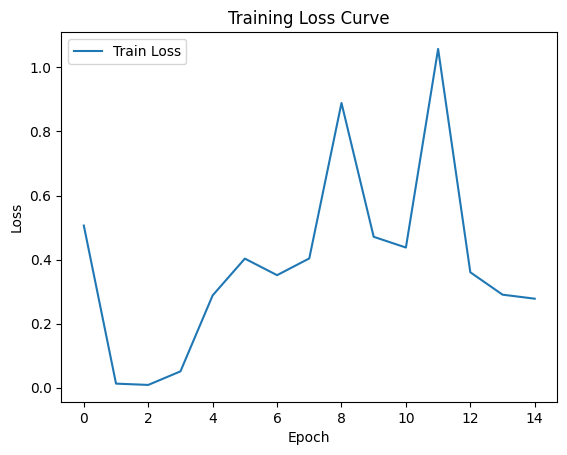

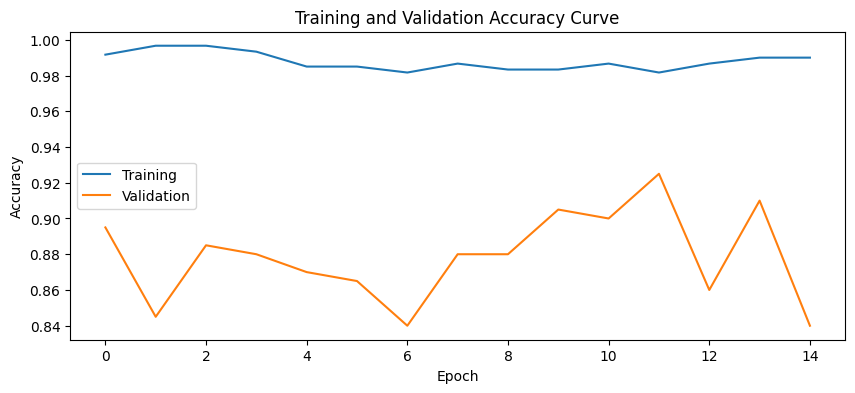

In [ ]:
'''
batch size = 128, lr = 0.001:
Train Accuracy: 0.9817, F1-Score: 0.9817, Loss: 1.0578
Valid Accuracy: 0.9250, F1-Score: 0.9256, Loss: 6.5344,
Best model path: /content/bs128_lr0.001_epoch11
'''

train_net(alexnet, train_loader, validation_loader, batch_size=128, lr=0.001, num_epochs=15)

### Learning rate (selected to be 0.0001)

Epoch 1/15
Train Accuracy: 0.7100, F1-Score: 0.7080, Loss: 73.8866
Valid Accuracy: 0.7650, F1-Score: 0.7722, Loss: 21.8802, 
Epoch 2/15
Train Accuracy: 0.8867, F1-Score: 0.8868, Loss: 6.4901
Valid Accuracy: 0.8750, F1-Score: 0.8739, Loss: 9.3687, 
Epoch 3/15
Train Accuracy: 0.9133, F1-Score: 0.9133, Loss: 4.5110
Valid Accuracy: 0.7950, F1-Score: 0.7730, Loss: 23.1334, 
Epoch 4/15
Train Accuracy: 0.9500, F1-Score: 0.9500, Loss: 4.9963
Valid Accuracy: 0.7900, F1-Score: 0.7703, Loss: 37.7775, 
Epoch 5/15
Train Accuracy: 0.9283, F1-Score: 0.9281, Loss: 8.3090
Valid Accuracy: 0.8400, F1-Score: 0.8352, Loss: 34.3382, 
Epoch 6/15
Train Accuracy: 0.9433, F1-Score: 0.9434, Loss: 7.4099
Valid Accuracy: 0.8450, F1-Score: 0.8397, Loss: 33.2026, 
Epoch 7/15
Train Accuracy: 0.9483, F1-Score: 0.9482, Loss: 8.4556
Valid Accuracy: 0.8250, F1-Score: 0.8240, Loss: 67.3977, 
Epoch 8/15
Train Accuracy: 0.9300, F1-Score: 0.9301, Loss: 18.1252
Valid Accuracy: 0.8250, F1-Score: 0.8199, Loss: 55.4747, 
Epoch 9

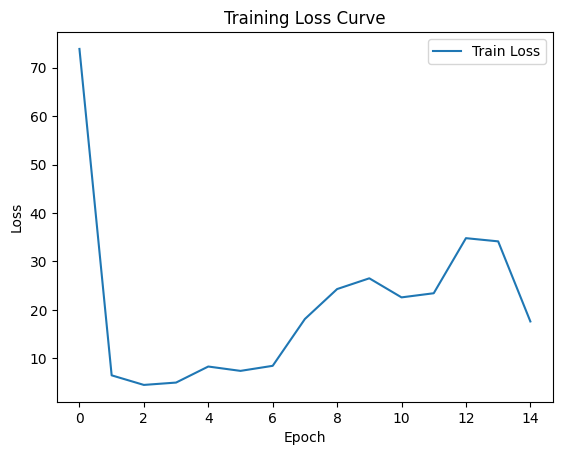

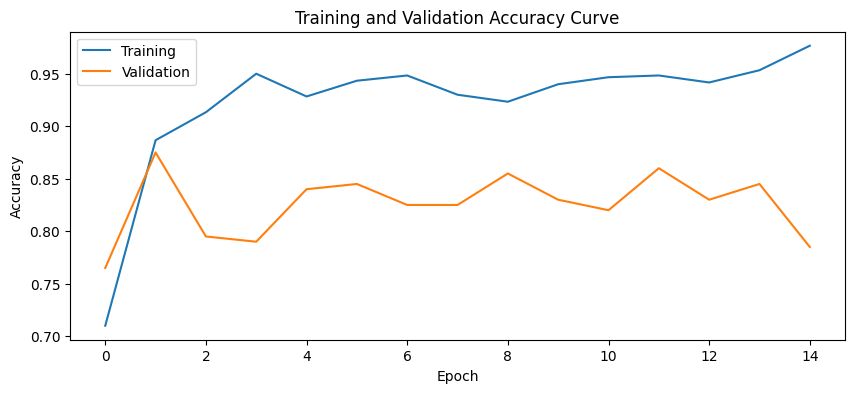

In [ ]:
'''
batch size = 64, lr = 0.01:
Train Accuracy: 0.9483, F1-Score: 0.9483, Loss: 23.4408
Valid Accuracy: 0.8600, F1-Score: 0.8584, Loss: 151.9566,
Best model path: /content/bs64_lr0.01_epoch11
'''

train_net(alexnet, train_loader, validation_loader, batch_size=64, lr=0.01, num_epochs=15)

Epoch 1/15
Train Accuracy: 0.9950, F1-Score: 0.9950, Loss: 0.4009
Valid Accuracy: 0.9200, F1-Score: 0.9204, Loss: 6.4162, 
Epoch 2/15
Train Accuracy: 0.9933, F1-Score: 0.9933, Loss: 0.2009
Valid Accuracy: 0.9200, F1-Score: 0.9203, Loss: 5.9291, 
Epoch 3/15
Train Accuracy: 0.9967, F1-Score: 0.9967, Loss: 0.0040
Valid Accuracy: 0.9150, F1-Score: 0.9152, Loss: 5.7557, 
Epoch 4/15
Train Accuracy: 0.9950, F1-Score: 0.9950, Loss: 0.1617
Valid Accuracy: 0.9100, F1-Score: 0.9099, Loss: 6.2997, 
Epoch 5/15
Train Accuracy: 1.0000, F1-Score: 1.0000, Loss: 0.0000
Valid Accuracy: 0.9050, F1-Score: 0.9048, Loss: 6.5061, 
Epoch 6/15
Train Accuracy: 1.0000, F1-Score: 1.0000, Loss: 0.0000
Valid Accuracy: 0.9050, F1-Score: 0.9048, Loss: 6.5494, 
Epoch 7/15
Train Accuracy: 0.9950, F1-Score: 0.9950, Loss: 0.1634
Valid Accuracy: 0.9300, F1-Score: 0.9300, Loss: 5.6429, 
Epoch 8/15
Train Accuracy: 0.9950, F1-Score: 0.9950, Loss: 0.0269
Valid Accuracy: 0.9250, F1-Score: 0.9250, Loss: 5.8646, 
Epoch 9/15
Train

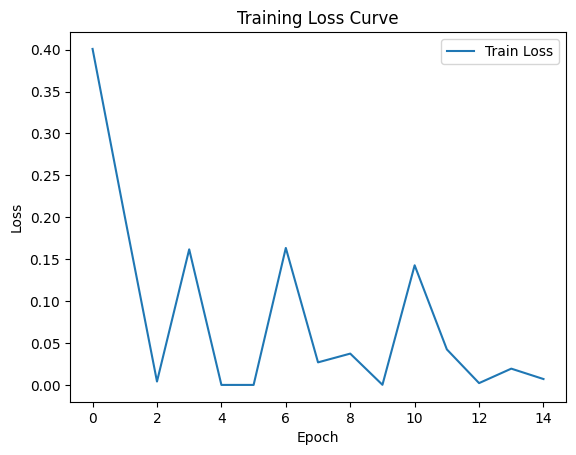

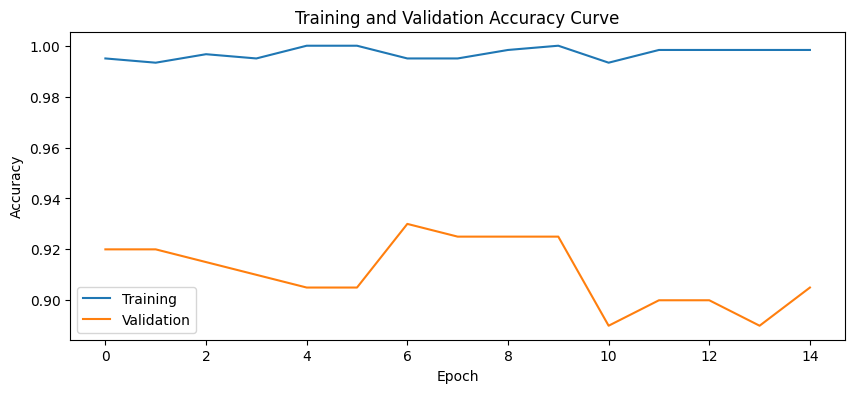

In [ ]:
'''
batch size = 64, lr = 0.0001:
Train Accuracy: 0.9950, F1-Score: 0.9950, Loss: 0.1634
Valid Accuracy: 0.9300, F1-Score: 0.9300, Loss: 5.6429,
Best model path: /content/bs64_lr0.0001_epoch6
'''

train_net(alexnet, train_loader, validation_loader, batch_size=64, lr=0.0001, num_epochs=15)

Epoch 1/15
Train Accuracy: 1.0000, F1-Score: 1.0000, Loss: 0.0000
Valid Accuracy: 0.9050, F1-Score: 0.9051, Loss: 5.9820, 
Epoch 2/15
Train Accuracy: 1.0000, F1-Score: 1.0000, Loss: 0.0001
Valid Accuracy: 0.9050, F1-Score: 0.9051, Loss: 5.9892, 
Epoch 3/15
Train Accuracy: 0.9983, F1-Score: 0.9983, Loss: 0.0374
Valid Accuracy: 0.9050, F1-Score: 0.9051, Loss: 5.9745, 
Epoch 4/15
Train Accuracy: 1.0000, F1-Score: 1.0000, Loss: 0.0001
Valid Accuracy: 0.9100, F1-Score: 0.9100, Loss: 6.0723, 
Epoch 5/15
Train Accuracy: 0.9983, F1-Score: 0.9983, Loss: 0.0941
Valid Accuracy: 0.9050, F1-Score: 0.9051, Loss: 6.1202, 
Epoch 6/15
Train Accuracy: 0.9983, F1-Score: 0.9983, Loss: 0.0731
Valid Accuracy: 0.9100, F1-Score: 0.9100, Loss: 6.2258, 
Epoch 7/15
Train Accuracy: 0.9967, F1-Score: 0.9967, Loss: 0.2137
Valid Accuracy: 0.9100, F1-Score: 0.9100, Loss: 6.3416, 
Epoch 8/15
Train Accuracy: 1.0000, F1-Score: 1.0000, Loss: 0.0000
Valid Accuracy: 0.9100, F1-Score: 0.9100, Loss: 6.3578, 
Epoch 9/15
Train

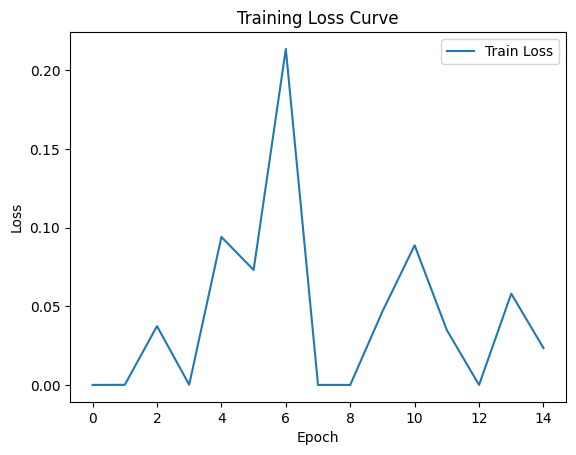

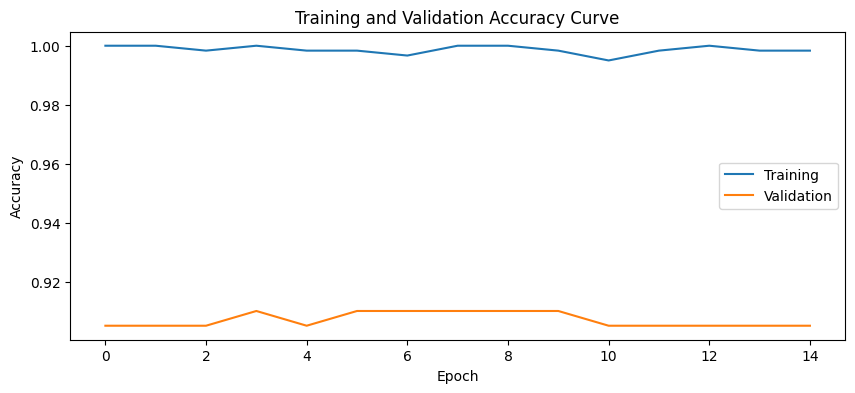

In [ ]:
'''
batch size = 64, lr = 0.00001:
Train Accuracy: 0.9983, F1-Score: 0.9983, Loss: 0.0731
Valid Accuracy: 0.9100, F1-Score: 0.9100, Loss: 6.2258,
Best model path: /content/bs64_lr0.00001_epoch5
'''

train_net(alexnet, train_loader, validation_loader, batch_size=64, lr=0.00001, num_epochs=15)

test the model path (to be deleted)

In [ ]:
best_model = alexnet
best_model_path = '/content/bs32_lr0.001_epoch9'  #REVISE
state = torch.load(best_model_path)
best_model.load_state_dict(state)

get_accuracy(best_model, validation_loader)

## Evaluate model on test dataset

In [ ]:
'''
TUNE BATCH SIZE
batch size = 32, lr = 0.001:
Train Accuracy: 0.9617, F1-Score: 0.9617, Loss: 0.3156
Valid Accuracy: 0.8800, F1-Score: 0.8803, Loss: 1.9768,
Best model path: /content/bs32_lr0.001_epoch9

batch size = 64, lr = 0.001:
Train Accuracy: 0.9933, F1-Score: 0.9933, Loss: 0.1022
Valid Accuracy: 0.9200, F1-Score: 0.9205, Loss: 5.0973,
Best model path: /content/bs64_lr0.001_epoch11

batch size = 128, lr = 0.001:
Train Accuracy: 0.9817, F1-Score: 0.9817, Loss: 1.0578
Valid Accuracy: 0.9250, F1-Score: 0.9256, Loss: 6.5344,
Best model path: /content/bs128_lr0.001_epoch11

TUNE LEARNING RATE
batch size = 64, lr = 0.01:
Train Accuracy: 0.9483, F1-Score: 0.9483, Loss: 23.4408
Valid Accuracy: 0.8600, F1-Score: 0.8584, Loss: 151.9566,
Best model path: /content/bs64_lr0.01_epoch11

batch size = 64, lr = 0.0001:
Train Accuracy: 0.9950, F1-Score: 0.9950, Loss: 0.1634
Valid Accuracy: 0.9300, F1-Score: 0.9300, Loss: 5.6429,
Best model path: /content/bs64_lr0.0001_epoch6

batch size = 64, lr = 0.00001:
Train Accuracy: 0.9983, F1-Score: 0.9983, Loss: 0.0731
Valid Accuracy: 0.9100, F1-Score: 0.9100, Loss: 6.2258,
Best model path: /content/bs64_lr0.00001_epoch5
'''

In [ ]:
best_model = alexnet
best_model_path = '/content/bs64_lr0.0001_epoch6'  #UPDATE
state = torch.load(best_model_path)
best_model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
get_accuracy(best_model, test_loader)

0.79

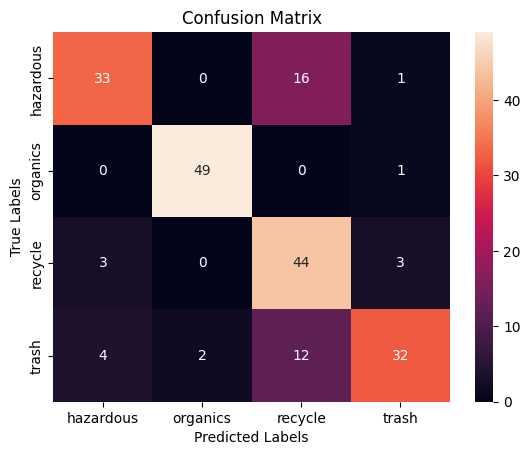

In [ ]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Then can move  model to the chosen device
alexnet.to(device)
alexnet.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Turn off gradients for test, saves memory and computations
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = alexnet(inputs)

        # Convert outputs probabilities to predicted class (0 or 1) using argmax
        _, preds = torch.max(outputs, 1)

        # Move the results back to CPU and convert them to numpy arrays if not already
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `y_true` and `y_pred` are your true and predicted labels:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')  # Set the label for the x-axis
plt.ylabel('True Labels')  # Set the label for the y-axis
# Set the tick labels on the x-axis and y-axis
plt.xticks(ticks=[0.5, 1.5, 2.5,3.5], labels=['hazardous', 'organics', 'recycle', 'trash'])
plt.yticks(ticks=[0.5, 1.5, 2.5,3.5], labels=['hazardous', 'organics', 'recycle', 'trash'])
plt.title('Confusion Matrix')
plt.show()